
# Welcome to Safran TP 1

<br>
<div style="text-align: justify"> 
Every day, more than 80,000 commercial flights take place around the world, operated by hundreds of airlines. For all aircraft take-off weight exceeding 27 tons, a regulatory constraint requires companies to systematically record and analyse all flight data, for the purpose of improving the safety of flights. Flight Data Monitoring strives to detect and prioritize deviations from standards set by the aircraft manufacturers, the authorities of civil aviation in the country, or even companies themselves. Such deviations, called events, are used to populate a database that enables companies to identify and monitor the risks inherent to these operations.
</div>
<br>
<div style="text-align: justify"> 
This notebook is designed to let you manipulate real aeronautical data, provided by the Safran Group. It is divided in two parts: the first part deals with the processing of raw data, you will be asked to visualize the data, understand what variables require processing and perform the processing for some of these variables. The second part deals with actual data analysis, and covers some interesting problems. We hope to give you some insights of the data scientist job and give you interesting and challenging questions.
</div>

In [144]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
sns.set_style("whitegrid")
from sklearn.preprocessing import MinMaxScaler,StandardScaler

<h1><div class="label label-success">Part 1: Data processing</div></h1>

## Loading the data

Load the **raw** data into the structure proposed below (the schema is given to you), using the code provided. The definition of the variables available is given here:

| var | description |
|:-----:|:-------------:|
| TIME   | elapsed seconds|
| LATP_1 | Latitude (°)|
| LONP_1 | Longitude (°)|
| RALT1 | Radio Altitude, sensor 1 (feet)|
| RALT2 | Radio Altitude, sensor 2 (feet)|
| RALT3 | Radio Altitude, sensor 3 (feet)|
| ALT_STD | Relative Altitude (feet)|
| HEAD | head (°)|
| PITCH | pitch (°)|
| ROLL | roll (°)|
| IAS | Indicated Air Speed (m/s)|
| N11 | speed N1 of the first engine (% of tr/min)|
| N21 | speed N2 of the first engine (% of tr/min)|
| N12 | speed N1 of the second engine (% of tr/min)|
| N22 | speed N2 of the second engine (% of tr/min)|
| AIR_GROUND | boolean, 0: ground, 1: air|

The sample rate is 1 Hz. You will be provided with `780` flight records. Each is a full record of a flight starting at the beginning of the taxi out phase and terminating at the end of the taxi in phase. Please be aware that due to side effects the very beginning of the record may be faulty. This is something to keep in mind when we will analyse the data.

** Note ** : `TIME` represents the elapsed seconds from today midnight. You are not provided with an absolute time variable that would tell you the date and hour of the flights.

You will need some expertise about the signification of the variables. Latitude and longitude are quite straightforward. Head, Pitch and Roll are standards orientation angles, check this [image](https://i.stack.imgur.com/65EKz.png) to be sure. RALT\* are coming from three different radio altimeters, they measure the same thing but have a lot of missing values and are valid only under a threshold altitude (around 5000 feet). Alt_std is the altitude measured from the pressure (it basically comes from a barometer), it is way less accurate that a radio altimeter but provides values for all altitudes. N1\* and N2\* are the rotational speeds of the engine sections expressed as a percentage of a nominal value. Some good links to check out to go deeper: 
- [about phases of flight](http://www.fp7-restarts.eu/index.php/home/root/state-of-the-art/objectives/2012-02-15-11-58-37/71-book-video/parti-principles-of-flight/126-4-phases-of-a-flight)
- [pitch-roll-head](https://i.stack.imgur.com/65EKz.png)
- [about N\*\* variables I](http://aviation.stackexchange.com/questions/14690/what-are-n1-and-n2)
- [about N\*\* variables II](https://www.quora.com/Whats-N1-N2-in-aviation-And-how-is-the-value-of-100-N1-N2-determined)
- [how altimeters work](http://www.explainthatstuff.com/how-altimeters-work.html)
- [about runway naming](https://en.wikipedia.org/wiki/Runway#Naming)

In [138]:
BASE_DIR = "/mnt/datasets/SAFRAN/data/"

from os import listdir
from os.path import isfile, join

import glob

import matplotlib as mpl
mpl.rcParams["axes.grid"] = True
import matplotlib.pylab as plt
%matplotlib inline

import numpy as np
import pandas as pd
pd.options.display.max_columns = 50

from datetime import datetime

# from haversine import haversine

def load_data_from_directory(DATA_PATH, num_flights):
    files_list = glob.glob(join(DATA_PATH, "*pkl"))
    print("There are %d files in total" % len(files_list))
    files_list = files_list[:num_flights]
    print("We process %d files" % num_flights)
    dfs = []
    p = 0
    for idx, f in enumerate(files_list):
        if idx % int(len(files_list)/10) == 0:
            print(str(p*10) + "%: [" + "#"*p + " "*(10-p) + "]", end="\r")
            p += 1
        dfs.append(pd.read_pickle(f))
    print(str(p*10) + "%: [" + "#"*p + " "*(10-p) + "]", end="\r")
    return dfs

# from IPython.core.display import HTML
# css = open('style-table.css').read()
# HTML('<style>{}</style>'.format(css))

<div class="label label-primary">Execute the cell below to load the data for part 1</div>

In [177]:
num_flights = 780
flights1 = load_data_from_directory(BASE_DIR + "part1/flights", num_flights)
for f in flights1:
    l = len(f)
    new_idx = pd.date_range(start=pd.Timestamp("now").date(), periods=l, freq="S")
    f.set_index(new_idx, inplace=True)

There are 780 files in total
We process 780 files


The data is loaded with pandas. Please take a look at the [pandas cheat sheet](https://github.com/pandas-dev/pandas/blob/master/doc/cheatsheet/Pandas_Cheat_Sheet.pdf) if you have any doubt. You are provided with 780 dataframes, each of them represents the records of the variables defined above during a whole flight.

`flights1` is a list where each item is a dataframe storing the data of one flight. There is no particular ordering in this list. All the flights depart from the same airport and arrive at the same airport. These airports are hidden to you and you will soon understand how.

For example `flights1[0]` is a dataframe, representing one flight.

In [4]:
flights1[0].head(20)

,TIME,LATP_1,LONP_1,HEAD,PITCH,ROLL,IAS,RALT1,RALT2,RALT3,ALT_STD,N11,N21,N22,N12,AIR_GROUND
2018-05-25 00:00:00,0,11.7731,33.3118,350.5,-0.9,-1.0,45.0,NaN,NaN,-4.0,-83.0,2.0,22.63,59.50,19.63,1.0
2018-05-25 00:00:01,1,11.7731,33.3118,350.5,-0.9,-1.0,45.0,-4.0,NaN,NaN,-83.0,2.0,23.75,59.38,19.75,1.0
2018-05-25 00:00:02,2,50.7330,21.2602,350.5,-0.9,-1.0,45.0,NaN,NaN,-4.0,-83.0,2.0,24.75,59.38,19.88,1.0
2018-05-25 00:00:03,3,48.0318,12.5277,350.1,-0.9,-1.0,45.0,NaN,-5.0,NaN,-84.0,3.0,25.63,59.50,20.00,1.0
2018-05-25 00:00:04,4,48.0318,12.5277,350.1,-0.9,-1.0,45.0,NaN,NaN,-4.0,-83.0,3.0,26.50,59.50,20.25,1.0
2018-05-25 00:00:05,5,48.0318,12.5277,349.8,-0.9,-1.0,45.0,-4.0,NaN,NaN,-84.0,3.0,27.13,59.38,20.50,1.0
2018-05-25 00:00:06,6,48.0318,12.5277,349.4,-0.9,-1.0,45.0,NaN,NaN,-4.0,-83.0,4.0,28.88,59.38,20.75,1.0
2018-05-25 00:00:07,7,48.0318,12.5277,349.4,-0.9,-1.0,45.0,NaN,-5.0,NaN,-82.0,5.0,30.50,59.38,20.63,1.0
2018-05-25 00:00:08,8,48.0318,12.5277,349.1,-0.9,-1.0,45.0,NaN,NaN,-4.0,-82.0,6.0,32.25,59.38,20.50,1.0
2018-05-25 00:00:09,9,48.0318,12.5277,349.4,-0.9,-1.0,45.0,-4.0,NaN,NaN,-82.0,6.0,34.00,59.38,20.38,1.0


You can select a column by indexing by its name.

In [5]:
flights1[0]["PITCH"].describe()

count    7704.000000
mean        2.005101
std         2.378875
min        -2.800000
25%         0.500000
50%         1.800000
75%         2.800000
max        16.000000
Name: PITCH, dtype: float64

Use `iloc[]` to select by line number, either the whole dataframe to obtain all the variables or an individual series.

In [6]:
flights1[0].iloc[50:60]

,TIME,LATP_1,LONP_1,HEAD,PITCH,ROLL,IAS,RALT1,RALT2,RALT3,ALT_STD,N11,N21,N22,N12,AIR_GROUND
2018-05-25 00:00:50,50,48.0314,12.5278,352.9,-0.9,-1.0,45.0,NaN,NaN,-4.0,-82.0,20.0,59.38,59.25,19.63,1.0
2018-05-25 00:00:51,51,48.0314,12.5278,352.9,-0.9,-1.0,45.0,NaN,-5.0,NaN,-81.0,20.0,59.50,59.38,19.50,1.0
2018-05-25 00:00:52,52,48.0314,12.5278,352.9,-0.9,-1.0,45.0,NaN,NaN,-4.0,-81.0,19.0,59.50,59.38,19.50,1.0
2018-05-25 00:00:53,53,48.0314,12.5278,352.9,-0.9,-1.0,45.0,-4.0,NaN,NaN,-81.0,19.0,59.50,59.38,19.50,1.0
2018-05-25 00:00:54,54,48.0314,12.5278,352.9,-0.9,-1.0,45.0,NaN,NaN,-4.0,-81.0,20.0,59.50,59.38,19.50,1.0
2018-05-25 00:00:55,55,48.0314,12.5278,352.9,-0.9,-1.0,45.0,NaN,-5.0,NaN,-81.0,20.0,59.50,59.38,19.50,1.0
2018-05-25 00:00:56,56,48.0314,12.5278,352.9,-0.9,-1.0,45.0,NaN,NaN,-4.0,-81.0,20.0,59.50,59.38,19.63,1.0
2018-05-25 00:00:57,57,48.0316,12.5278,352.9,-0.9,-1.0,45.0,-4.0,NaN,NaN,-81.0,20.0,59.50,59.38,19.75,1.0
2018-05-25 00:00:58,58,48.0316,12.5278,352.9,-0.9,-1.0,45.0,NaN,NaN,-4.0,-81.0,20.0,59.50,59.38,19.75,1.0
2018-05-25 00:00:59,59,48.0316,12.5278,352.9,-0.9,-1.0,45.0,NaN,-5.0,NaN,-82.0,20.0,59.50,59.38,19.75,1.0


In [7]:
flights1[0]["PITCH"].iloc[50:60]

2018-05-25 00:00:50   -0.9
2018-05-25 00:00:51   -0.9
2018-05-25 00:00:52   -0.9
2018-05-25 00:00:53   -0.9
2018-05-25 00:00:54   -0.9
2018-05-25 00:00:55   -0.9
2018-05-25 00:00:56   -0.9
2018-05-25 00:00:57   -0.9
2018-05-25 00:00:58   -0.9
2018-05-25 00:00:59   -0.9
Freq: S, Name: PITCH, dtype: float64

## Visualization

To perform monitoring of flights, it is necessary to clean up the data. To start, it is important to visualize the data that is available, in order to understand better their properties and the problems associated with them (noise, statistical characteristics, <del>ladders</del>, features and other values).

<div class="alert alert-info">
<h3><div class="label label-default">Question 1</div>  <div class="label label-info">Visualize all the variables</div></h3>
<br>
For an arbitrary flight, for example <code>flights1[0]</code>, visualize all the variables. Would you rather use plot or scatter? Interpolate the data or not interpolate? Think about NaN values and how they are treated when we plot a series. Comment.
</div>

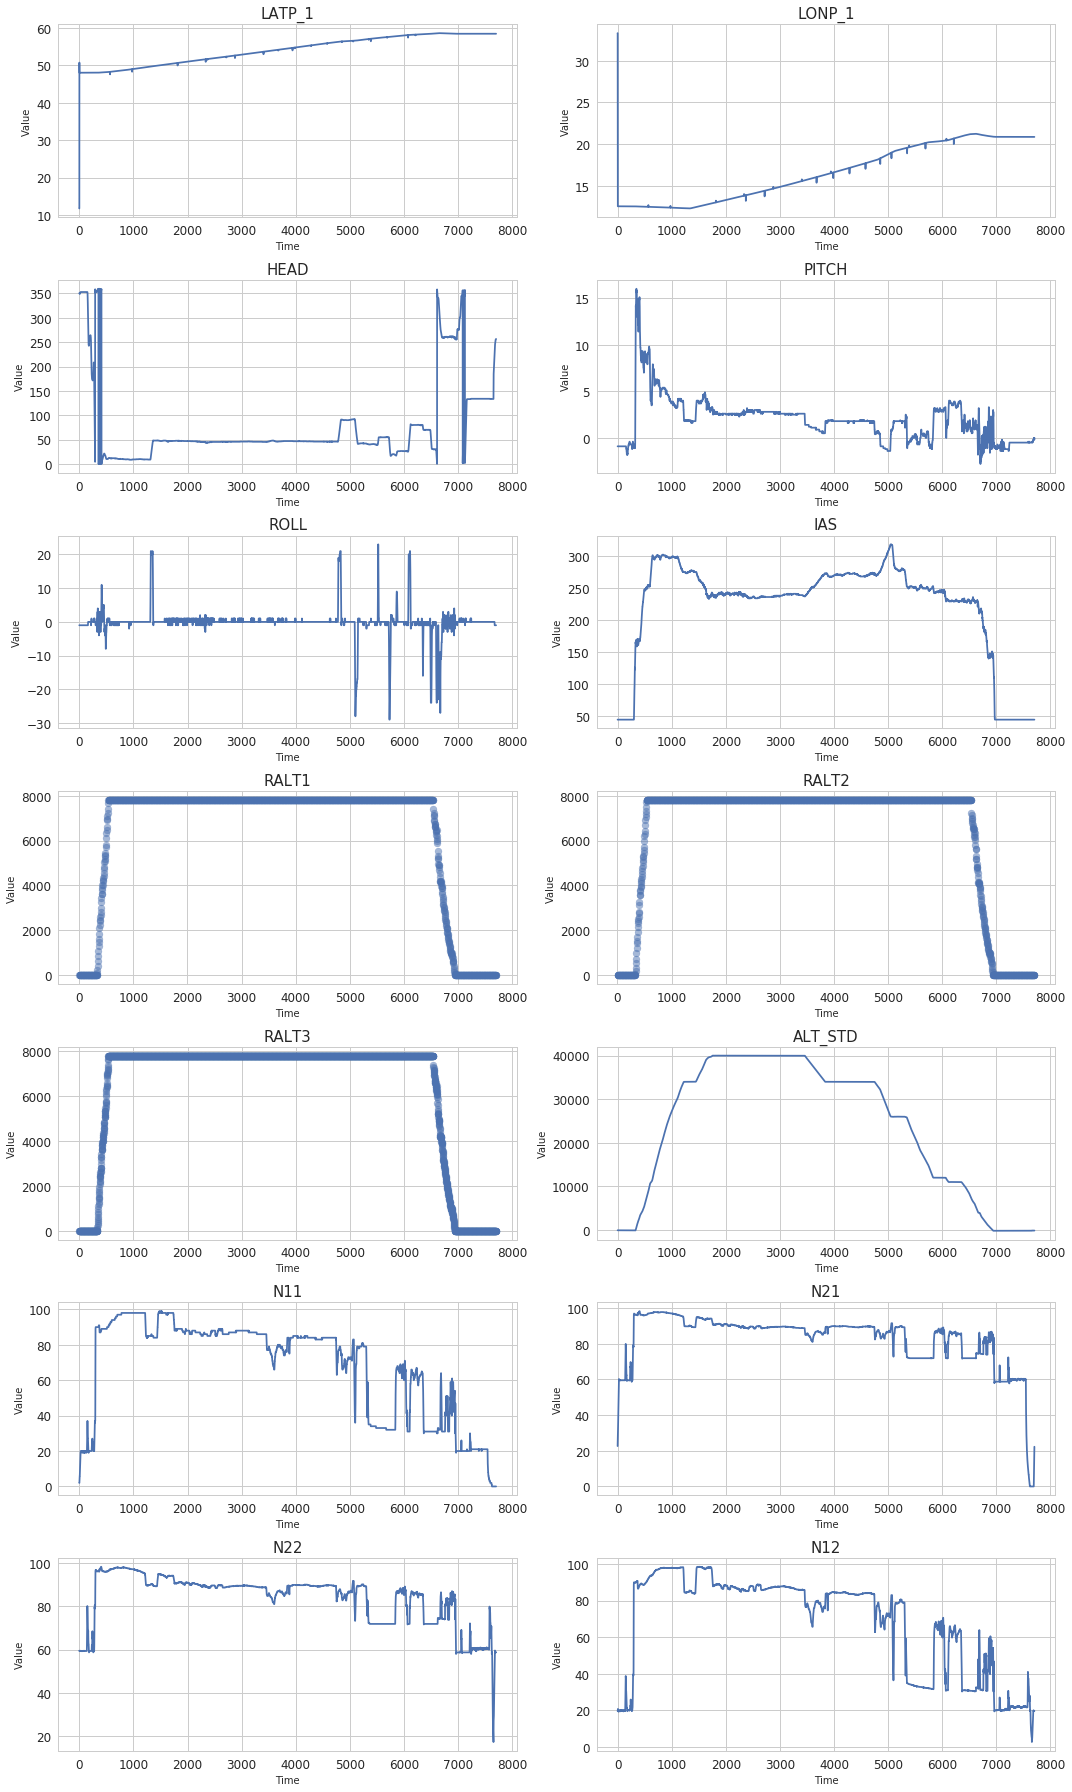

In [150]:
f, axarr = plt.subplots(7, 2, figsize=(15,25))

k = 0

feature_list = list(flights1[0].drop(['TIME', 'AIR_GROUND'], axis=1).columns)
feature_scatter = ['RALT1', 'RALT2', 'RALT3']

for col in feature_list:
    (i, j) = divmod(k, 2)
    if col in feature_scatter:
        axarr[i,j].scatter(np.arange(len(flights1[0][col])), flights1[0][col], alpha=0.5)
    else:
        axarr[i,j].plot(np.arange(len(flights1[0][col])), flights1[0][col])
    axarr[i,j].set_title(col, fontsize=15)
    axarr[i,j].yaxis.set_tick_params(labelsize=12)
    axarr[i,j].xaxis.set_tick_params(labelsize=12)
    axarr[i,j].set_xlabel("Time",fontsize=10)
    axarr[i,j].set_ylabel("Value",fontsize=10)
    k += 1
    plt.tight_layout()
plt.show()

<div class="alert alert-success">
  <strong>Answer 1</strong>
  <p>For most of our attributes the best approach was to use a plot rather than a scatter. Indeed, when there are few missing values, using a plot gives a better visualization of the data because it provides an automatic interpolation. Instead, in cases like RALT1, RALT2 and RALT3, where the most our data is missing, using a scatter is a better approach because, otherwise, we would have a distorted visualization of our data as we would have too many gaps and the interpolation may be misleading.</p>
</div>

If it is interesting to see the variables for a given flight, it is more informative to view the set of values for all flights in order to understand what are the significant/normal values and what are those which are abnormal.

<div class="alert alert-info">
<h3><div class="label label-default">Question 2</div>  <div class="label label-info">Visualize N21 variable for all flights</div></h3>
<br>
For the <code>N21</code> variable, for example, display all of the flights on the same figure. Use alpha parameter to add transparency to your plot. Is there any pattern? Comment the variabilities you observe.
</div>

In [19]:
n21 = [f['N21'] for f in flights1]

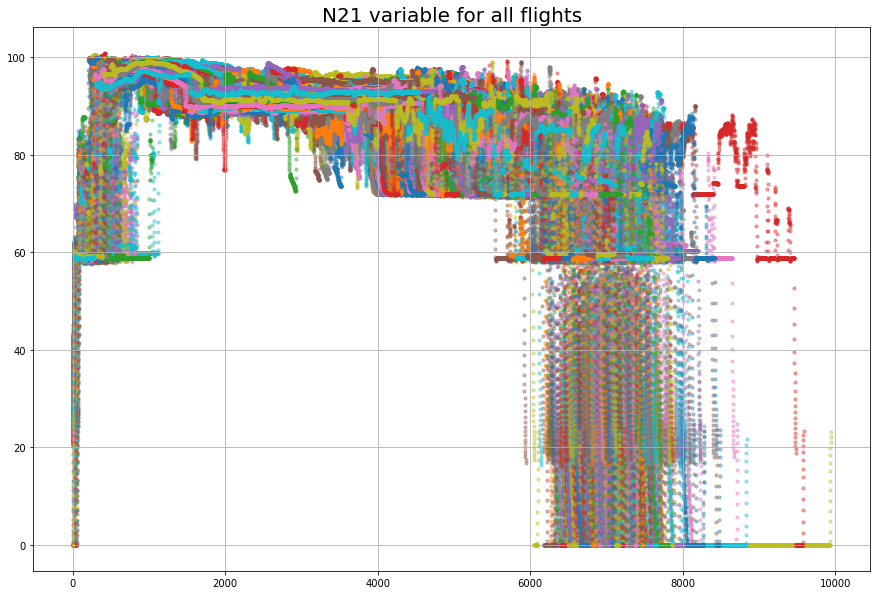

In [34]:
plt.figure(figsize=(15,10))
for i, n in enumerate(n21):
    plt.scatter(np.arange(len(n)), n, alpha=0.4, label=i, s =10)
plt.title('N21 variable for all flights', fontsize=20)
plt.show()

<div class="alert alert-success">
  <strong>Answer 2</strong><p>Even though the plot is quite crowded, we can notice a general pattern in all the flights for the N21 variable (speed N1 of the first engine). Indeed, since all the flights are between the same departure and destination airports and the trajectory is more or less common to all flights, they should also have more or less the same engine speed throughout the cruise. Anyway we can notice that there are flights which are faster then others i.e. the engine speed goes to 0 earlier in our plot. This is due to the fact that the trajectory may be slightly different between flights.</p>
</div>

Some variables must be analyzed together, such as latitude and longitude, otherwise the visualization information will be incomplete, we could be missing something.

<div class="alert alert-info">
<h3><div class="label label-default">Question 3</div>  <div class="label label-info">Visualize latitude against longitude for all flights</div></h3>
<br>
Display the trajectories (<code>LONP_1</code>, <code>LATP_1</code>) of the first 20 flights, that is <code>flights1[:20]</code>. What do you see? Keep in mind that the data during the beginning of the recording may be abnormal. What insight do you lose when you plot <code>LONP_1</code> against <code>LATP_1</code> ?
</div>

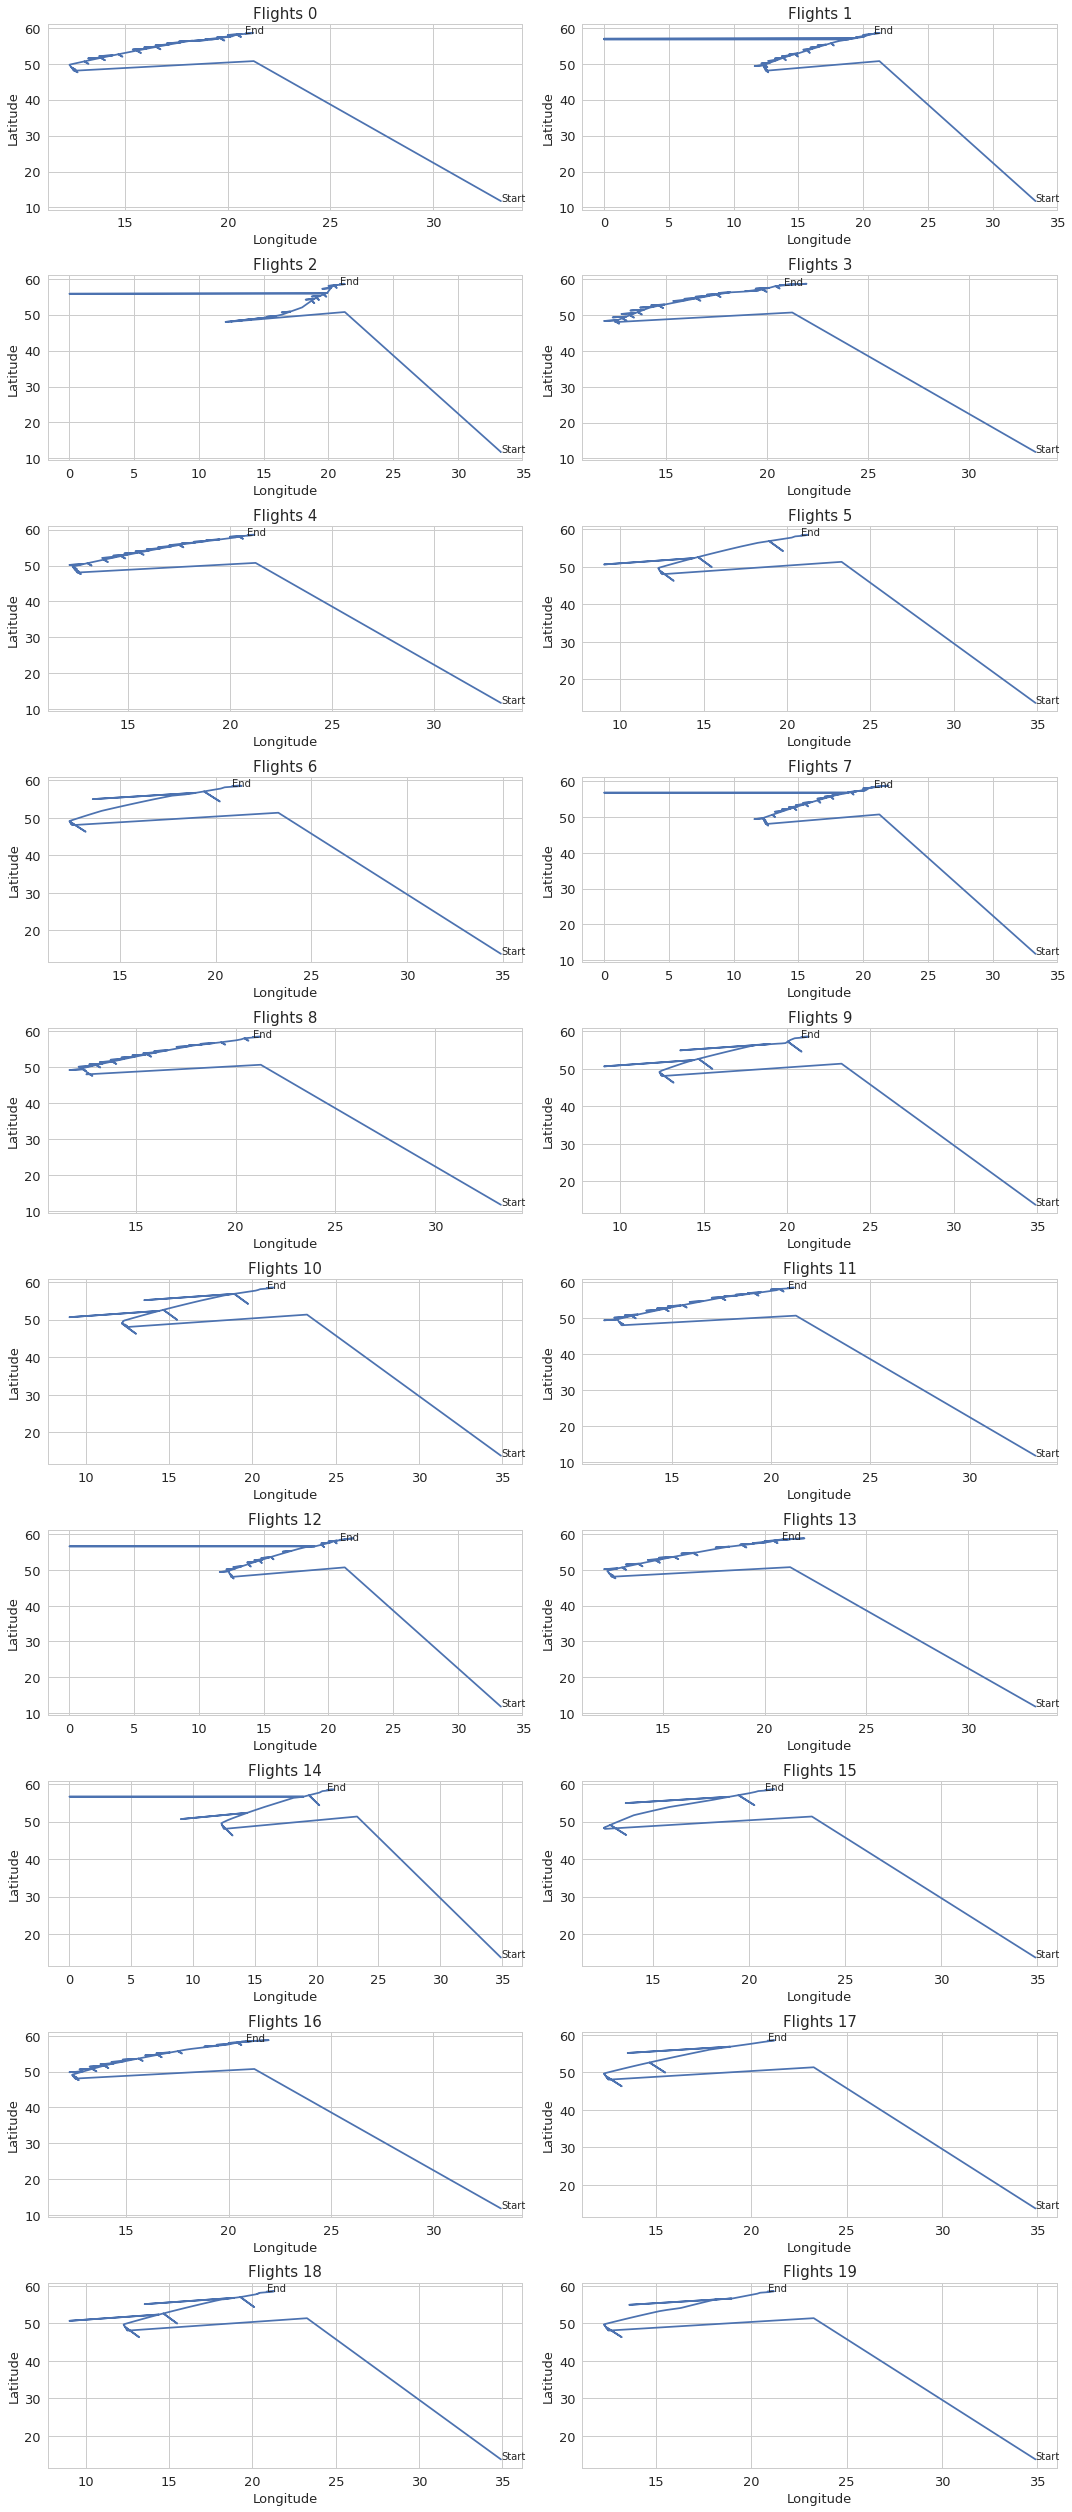

In [154]:
# your code goes here ...
latitudes = [f['LATP_1'] for f in flights1[:20]]
longitudes = [f['LONP_1'] for f in flights1[:20]]

f, axarr = plt.subplots(10, 2, figsize=(15,35))

k = 0


for i, (lat, long) in enumerate(zip(latitudes,longitudes)):
    (i, j) = divmod(k, 2)
    
    axarr[i,j].plot(long,lat)
    axarr[i,j].set_title('Flights '+str(k), fontsize=15)
    axarr[i,j].yaxis.set_tick_params(labelsize=13)
    axarr[i,j].set_xlabel('Longitude',fontsize=13)
    axarr[i,j].set_ylabel('Latitude',fontsize=13)
    axarr[i,j].xaxis.set_tick_params(labelsize=13)
    axarr[i,j].annotate('Start', xy=(long[0], lat[0]))
    axarr[i,j].annotate('End', xy=(long[-1], lat[-1]))

    k += 1

plt.tight_layout()
plt.show()

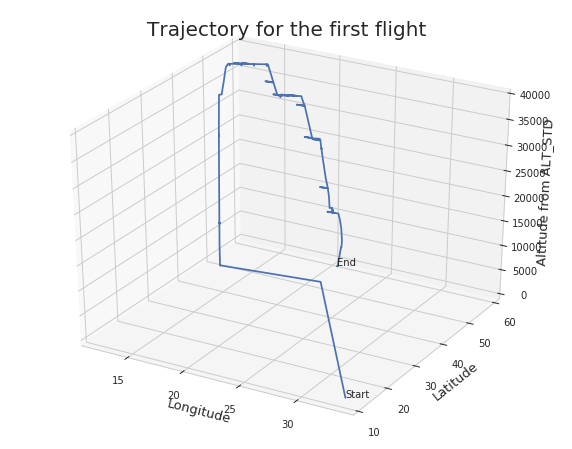

In [153]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')
ax.set_title('Trajectory for the first flight', fontsize=20)
ax.plot(flights1[0]['LONP_1'], flights1[0]['LATP_1'],flights1[0]['ALT_STD'])
ax.set_xlabel('Longitude',fontsize=13)
ax.set_ylabel('Latitude',fontsize=13)
ax.set_zlabel('Altitude from ALT_STD',fontsize=13)
ax.text(flights1[0]['LONP_1'][0], flights1[0]['LATP_1'][0],flights1[0]['ALT_STD'][0], 'Start')
ax.text(flights1[0]['LONP_1'][-1], flights1[0]['LATP_1'][-1],flights1[0]['ALT_STD'][-1], 'End')
plt.show()

<div class="alert alert-success">
  <strong>Answer 3</strong><p>The first thing we notice is the fact that all the flights have more or less the same trajectory. Indeed they are all flying between the same airports.</p>
  <p>Another thing which is clearly visible from the 3d plot of the trajectory of the first flight in our dataset, is the fact that the first part of the data flight is abnormal as the altitude remain to zero for a too long period of time. It is possible that the sensor measuring altitude may require some time before being able to provide reliable measurements.</p>
  <p>While plotting lotitude against langitude, however, we lose the insight regarding the flying time.</p>
</div>

Keep in mind that our goal is to understand the nature and the inherent problems of our data, and its features. Proceed with the visual analysis of the data, looking at different features.

<div class="alert alert-info">
<h3><div class="label label-default">Question 4</div>  <div class="label label-info">Recap variables that require pre-processing</div></h3>
<br>
Based on your observations as for now, what are the variables requiring processing? For each of these variables, specify the necessary pre-processing required prior to perform data analysis.
</div>

In [155]:
def compute_missing_values(dataset):
    tmp_df = dataset.drop(['TIME'], axis=1)
    total = tmp_df.isnull().sum().sort_values(ascending=False)
    percent = (tmp_df.isnull().sum()/tmp_df.isnull().count() * 100).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percentage'])
    return missing_data[missing_data['Percentage'] > 0]

In [156]:
missing_values = [compute_missing_values(f) for f in flights1[:20]]

In [157]:
for i in range(len(missing_values)):
    print('-'*35)
    print('Missing values for Flight', i)
    print(missing_values[i])

-----------------------------------
Missing values for Flight 0
       Total  Percentage
RALT2   5778        75.0
RALT1   5778        75.0
RALT3   3852        50.0
-----------------------------------
Missing values for Flight 1
       Total  Percentage
RALT2   5085        75.0
RALT1   5085        75.0
RALT3   3390        50.0
-----------------------------------
Missing values for Flight 2
       Total  Percentage
RALT2   5241        75.0
RALT1   5241        75.0
RALT3   3494        50.0
-----------------------------------
Missing values for Flight 3
       Total  Percentage
RALT2   5649        75.0
RALT1   5649        75.0
RALT3   3766        50.0
-----------------------------------
Missing values for Flight 4
       Total  Percentage
RALT2   4995        75.0
RALT1   4995        75.0
RALT3   3330        50.0
-----------------------------------
Missing values for Flight 5
       Total  Percentage
N12     5157        75.0
N11     5157        75.0
RALT2   5157        75.0
RALT1   5157    

<div class="alert alert-success">
  <strong>Answer 4</strong>
  <p>As we can see there is a general pattern in the amount of missing values in our flights dataset. In fact, the attributes RALT1, RALT2 and RALT3 always present the same amount of mising values. Anyway, we will deal with those values later in this notebook.</p>
  <p>In some cases we also have missing values for the N12 and N11 features. Those features represent the speed of the first engine and the speed of the second engine respectively and, when they present missing values, the missing values amount is always the same (75% of the total). We assumed that those values are missing because, probably, during certain stages of the flight cruise some engines may be turned off for resource utilization optimization. For example, we believe that in the departing stage all engines must be used while, during the cruise stage the power of all the engines may not be needed. Therefore we could handle them by replacing missing values with zeros.</p>
</div>

It is important to undestand the links between variables, to understand how a system works.

<div class="alert alert-info">
<h3><div class="label label-default">Question 5</div>  <div class="label label-info">Correlation between variables</div></h3>
<br>
 Compute the correlation of each normalized variables with any others for one flight.
Compute delay and max value for each pair of variables.
What happens if you do not normalize ?
What are the most correlated variables or group of variables ?
Can you comment about the delay between variables ?
</div>

In [158]:
def correlation(x,y):
    all_correlations = np.correlate(x,y)
    maximum_correlation = np.max(all_correlations)
    delay = np.argmax(all_correlations)-x.shape[0]+1
    return maximum_correlation, delay   

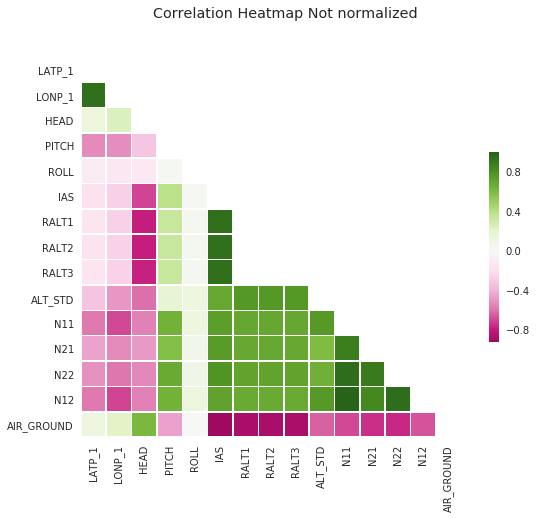

In [159]:
# your code goes here ...
plt.figure(figsize=(10,7))
sns.set(style="white")

# Drop the Id and SalePrice features because it is irrelevant to our purpose
# We will take a look at SalePrice later
corr = flights1[0].drop(['TIME'],axis=1).corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr, cmap='PiYG', mask=mask, square=True,linewidths=.5, cbar_kws={"shrink": .5},center=0)
plt.suptitle('Correlation Heatmap Not normalized')
plt.show()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  if sys.path[0] == '':


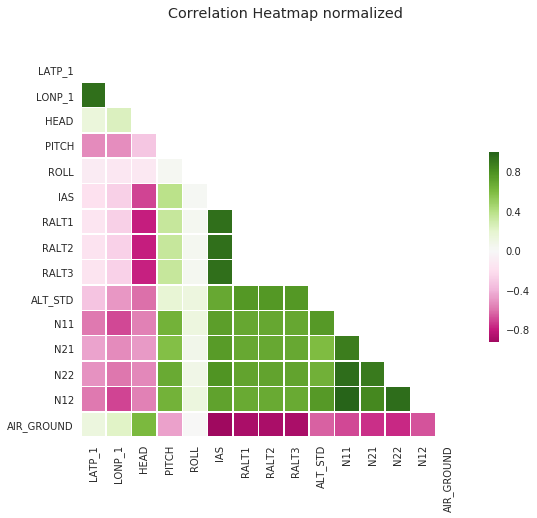

In [160]:
plt.figure(figsize=(10,7))
sns.set(style="white")

# Drop the Id and SalePrice features because it is irrelevant to our purpose
# We will take a look at SalePrice later
data = flights1[0].drop(['TIME'],axis=1).copy()

scaler = MinMaxScaler()

for col in data.columns:
    null_index = data[col].isnull()
    tmp = scaler.fit_transform(data.loc[~null_index, col].reshape(-1, 1))
    data.loc[~null_index, col] = tmp.reshape(-1)
    
corr = data.corr()
    
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr, cmap='PiYG', mask=mask, square=True,linewidths=.5, cbar_kws={"shrink": .5},center=0)
plt.suptitle('Correlation Heatmap normalized')
plt.show()

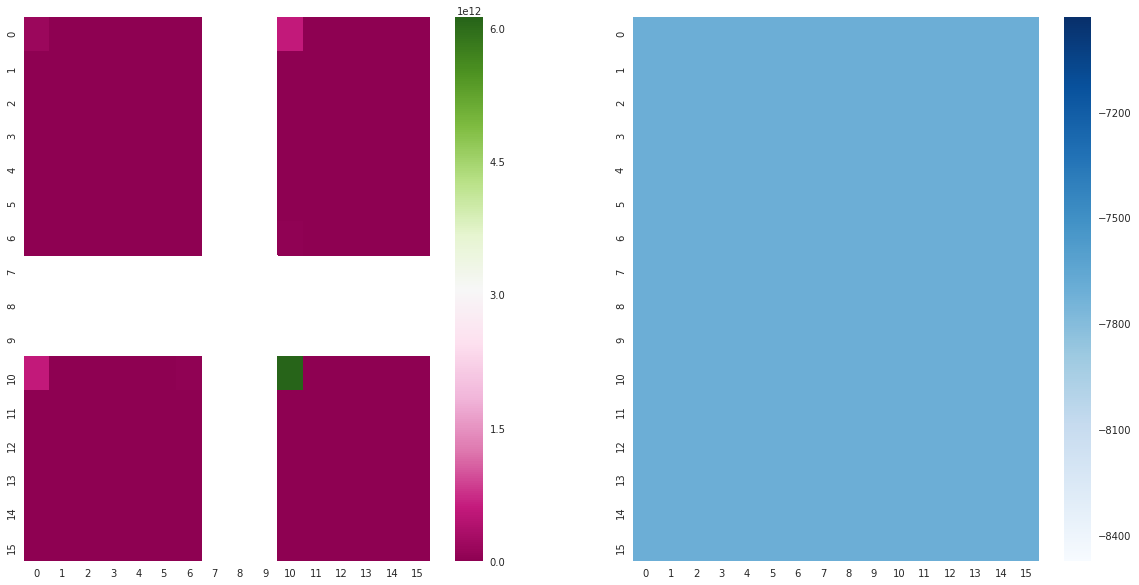

In [178]:
sns.set_style("whitegrid")
size = len(flights1[0].columns)
max_corr = np.zeros((size,size))
delay = np.zeros((size,size))

for i, col1 in enumerate(flights1[0].columns):
    for j, col2 in enumerate(flights1[0].columns):
        max_corr[i,j], delay[i,j] = correlation(flights1[0][col1], flights1[0][col2])

f, axarr = plt.subplots(1, 2, figsize=(20,10))
ax = sns.heatmap(max_corr,cmap='PiYG' ,ax=axarr[0])
ax = sns.heatmap(delay,cmap='Blues', ax=axarr[1] )

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  


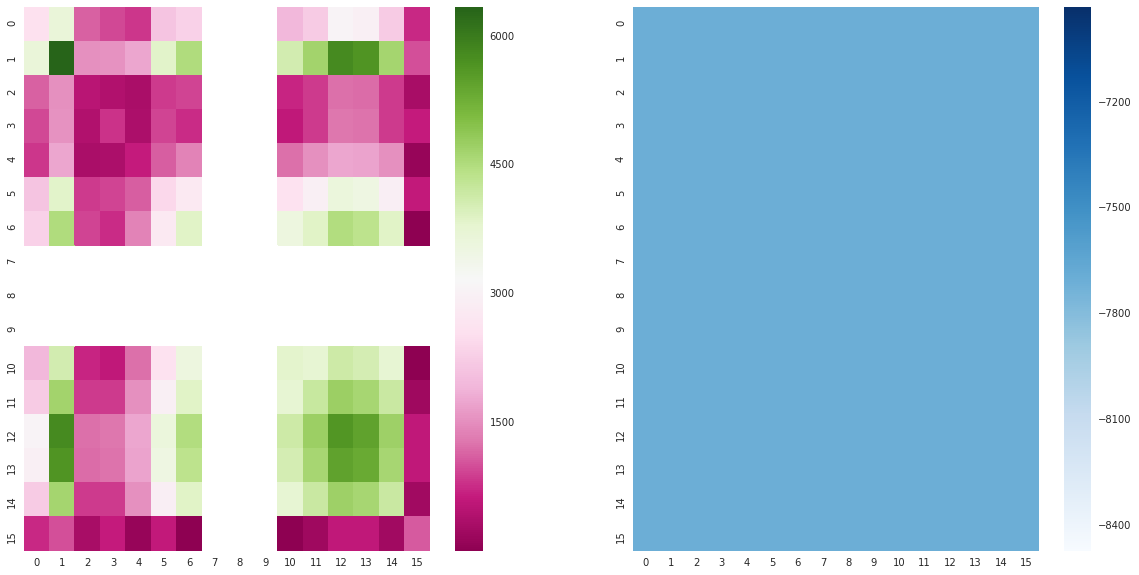

In [175]:
scaler = MinMaxScaler()
data = flights1[0].copy()

for col in data.columns:
    null_index = data[col].isnull()
    tmp = scaler.fit_transform(data.loc[~null_index, col].reshape(-1, 1))
    data.loc[~null_index, col] = tmp.reshape(-1)
    
for i, col1 in enumerate(data.columns):
    for j, col2 in enumerate(data.columns):
        max_corr[i,j], delay[i,j] = correlation(data[col1], data[col2])
        
f, axarr = plt.subplots(1, 2, figsize=(20,10))
ax = sns.heatmap(max_corr,cmap='PiYG', ax=axarr[0] )
ax = sns.heatmap(delay,cmap='Blues', ax=axarr[1] )

<div class="alert alert-success">
  <strong>Answer 5</strong>
  <p>Additionally to the requested matrixes, we also plotted the correlation matrix of each feature of our dataset, just to see which features mostly influence the others. We did this both for normalized and non-normalized data and, as we were expecting, they did not change at all. What we can notice from those plots is that the engine speed features are all correlated between each other and so are latitude and longitude.</p>
  <p>In the second set of plots, in which we plotted the cross-correlation and the delay between each feature, we noticed that normalizing the data changed the cross-correlation matrix.</p>
</div>

## Pre-processing

Data pre-processing is essential, in order to separate the errors due to measurement from "normal" data variability, which is representative of the phenomenon that interests us.

<div class="alert alert-info">
<h3><div class="label label-default">Question 6</div>  <div class="label label-info">Smooth and filter out abnormal data in trajectories (LATP_1 and LONP_1)</div></h3>
<br>
Filter the flight trajectories (<code>LATP_1</code> and <code>LONP_1</code> variables). You can focus on the first 20 flights, that is <code>flights1[:20]</code>. Display the trajectories before and after smoothing.
</div>

```python
# this is a template code, fill in the blanks, or use your own code

# Only work with the first few flights
fs = flights1[:20]

# Set up the figure to plot the trajectories before (ax0) and after smoothing (ax1)
fig, axarr = plt.subplots(1, 2)
fig.set_figwidth(15)
ax0, ax1 = axarr

for f in fs:
    f["LATP_1_C"] = f.LATP_1.rolling(window=...).... # FILL IN THE BLANKS
    f["LONP_1_C"] = f.LONP_1.rolling(window=...).... # FILL IN THE BLANKS

for f in fs:
    f.plot(kind="scatter", x="LATP_1", y="LONP_1", s=1, ax=ax0) # plot raw trajectory
    f.plot(kind="scatter", x="LATP_1_C", y="LONP_1_C", s=1, ax=ax1) # plot smoothed trajectory
    
    
fig.tight_layout()

```

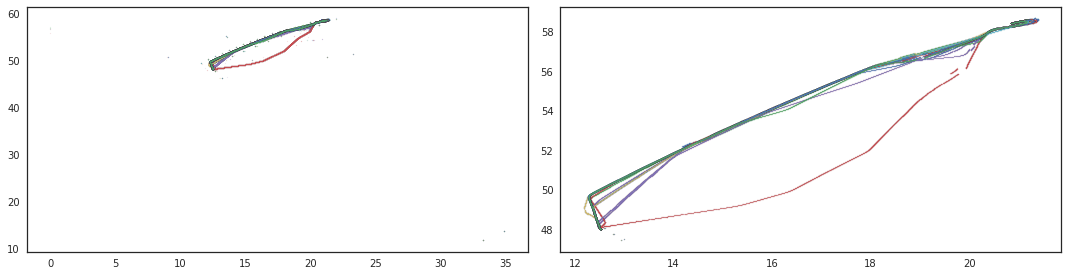

In [88]:
# Only work with the first few flights
fs = flights1[:20]

# Set up the figure to plot the trajectories before (ax0) and after smoothing (ax1)
fig, axarr = plt.subplots(1, 2)
fig.set_figwidth(15)
ax0, ax1 = axarr

for f in fs:
    f["LATP_1_C"] = f.LATP_1.rolling(window=120).mean() # FILL IN THE BLANKS
    f["LONP_1_C"] = f.LONP_1.rolling(window=120).mean() # FILL IN THE BLANKS

for f in fs:
    ax0.scatter(f["LONP_1"],  f["LATP_1"], s=1,alpha=0.1) # plot raw trajectory
    ax1.scatter( f["LONP_1_C"], f["LATP_1_C"],s=1, alpha=0.1) # plot smoothed trajectory

fig.tight_layout()

<div class="alert alert-info">
<h3><div class="label label-default">Question 7</div>  <div class="label label-info">Pre-process HEAD, get rid off discontinuities</div></h3>
<br>
Angles are special variables because they "cycle" over their range of values. The <code>HEAD</code> variable shows artificial discontinuities: your goal is to eliminate (filter out) such discontinuities. The angle may no longer be between 0 and 360 degrees after the transformation but it will come very handy for some analysis later. Display the data before and after transformation. You can focus on one flight, for example <code>flights1[0]</code>.
</div>

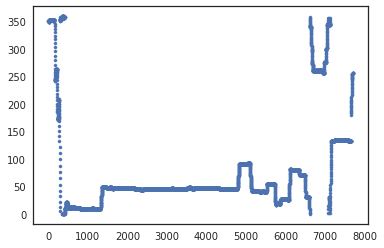

In [93]:
# your code goes here ...
plt.scatter(range(len(flights1[0])), flights1[0]['HEAD'], s=10)
plt.show()

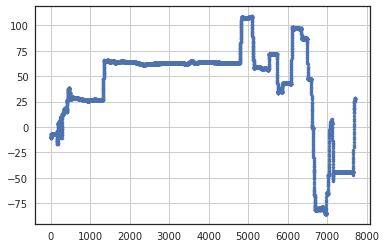

In [126]:
flights1[0]['HEAD_c'] = np.unwrap(flights1[0]["HEAD"])-360

       
plt.scatter(range(len(data)), flights1[0]['HEAD_c'], s=10)

<div class="alert alert-success">
  <strong>Answer 7</strong>
  <p>We used the NumPy unwrap function that unwraps radian phase p by changing absolute jumps greater than pi to their 2*pi complement. </p>
  <p> We also subtracted 360 degree in order to get a range between -180 and 180 because we find it more clear </p>
</div>

<div class="alert alert-info">
<h3><div class="label label-default">Question 8</div>  <div class="label label-info">All data on the same time base</div></h3>
<br>When we make an analysis, it is important to have the maximum of information. However, for any flight, you can see that there is three RALT (<code>RALT1</code>, <code>RALT2</code>, <code>RALT3</code>). They are not at the same sampling rate.
Use interpolation on one flight, for example <code>flights1[0]</code>,to have them at the same sampling rate of 1Hz. Then, merge your results. Can you comment on the method you used ?
</div>

In [136]:

# your code goes here ...
flights1[0]['RALT_c'] = flights1[0].RALT1.combine_first(flights1[0].RALT2).combine_first(flights1[0].RALT3)
features = ['RALT1','RALT2','RALT3','RALT_c']
flights1[0][features].head(10)

,RALT1,RALT2,RALT3,RALT_c
2018-05-25 00:00:00,NaN,NaN,-4.0,-4.0
2018-05-25 00:00:01,-4.0,NaN,NaN,-4.0
2018-05-25 00:00:02,NaN,NaN,-4.0,-4.0
2018-05-25 00:00:03,NaN,-5.0,NaN,-5.0
2018-05-25 00:00:04,NaN,NaN,-4.0,-4.0
2018-05-25 00:00:05,-4.0,NaN,NaN,-4.0
2018-05-25 00:00:06,NaN,NaN,-4.0,-4.0
2018-05-25 00:00:07,NaN,-5.0,NaN,-5.0
2018-05-25 00:00:08,NaN,NaN,-4.0,-4.0
2018-05-25 00:00:09,-4.0,NaN,NaN,-4.0


<div class="alert alert-success">
<strong>Answer 8</strong>
We create an additional feature, called RALT_c, where for each row, we merged the information coming from RALT1, RALT2 and RALT3, taking the only not NaN value. 
</div>

<h1><div class="label label-success">Part 2: Analysis</div></h1>

We now turn to the data analysis task. In this part, we will use a **clean** dataset, which has been prepared for you; nevertheless, the functions you developed in the first part of the notebook can still be used to visualize and inspect the new data. Next, we display the schema of the new dataset you will use:

| var | description |
|:-----:|:-------------:|
| TIME   |elapsed seconds|
| **LATP_C** | **Latitude (°), Corrected**|
| **LONP_C** | **Longitude (°), Corrected**|
| **RALT_F** | **Radio Altitude (feet), Fusioned**|
| **ALT_STD_C** | **Relative Altitude (feet), Corrected**|
| **HEAD_C** | **head (°), Corrected**|
| **HEAD_TRUE** | **head (°), without discontinuities**|
| **PITCH_C** | **pitch (°), Corrected**|
| **ROLL_C** | **roll (°), Corrected**|
| **IAS_C** | **Indicated Air Speed (m/s), Corrected**|
| N11 | speed N1 of the first engine (% of tr/min)|
| N21 | speed N2 of the first engine (% of tr/min)|
| N12 | speed N1 of the second engine (% of tr/min)|
| N22 | speed N2 of the second engine (% of tr/min)|
| AIR_GROUND | status in the air (Boolean)|

<div class="label label-primary">Execute the cell below to load the data for part 2</div>

In [15]:
num_flights = 780
flights2 = load_data_from_directory(BASE_DIR + "part2/flights/", num_flights)
for f in flights2:
    l = len(f)
    new_idx = pd.date_range(start=pd.Timestamp("now").date(), periods=l, freq="S")
    f.set_index(new_idx, inplace=True)

There are 780 files in total
We process 780 files


In this part, we will try to modelize a time series with simple models. In particular, we will look at the landing, and the N1 variable.

<div class="label label-primary">
 First, look at the variables for the flight 0, by executing the following code.
</div>

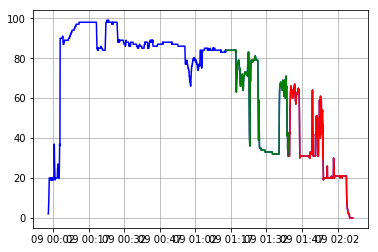

In [16]:
plt.plot(flights2[0]['N11'], 'b')
index_start = 4500
tomodel = flights2[0]['N11'][index_start:index_start+1600] 
topredict = flights2[0]['N11'][index_start+1600:index_start+3600] 
plt.plot(tomodel, 'g')
plt.plot(topredict, 'r')


<div class="alert alert-info">
<h3><div class="label label-default">Question 9</div>  <div class="label label-info">Modelization of time series</div></h3>
<br>
Is it stationary ? The augmented Dickey-Fuller test is a popular test to test the null hypothesis that a time series sample is non-stationary. Use this test to confirm what you observed.
</div>

In [17]:
import scipy.stats.stats as stats
from statsmodels.tsa.stattools import adfuller
# your code goes here




DFtest_brut = ...
print('Augmented D-F test before detrending:')
print('p-value = ' + str(DFtest_brut))

Augmented D-F test before detrending:
p-value = Ellipsis


Your comment goes here ...

<div class="alert alert-info">
<h3><div class="label label-default">Question 10</div>  <div class="label label-info">Modelization of time series</div></h3>
<br>
We may want to detrend the time serie. Fit a polynom or order 3 to the sequence <code>tomodel</code>, remove the trend and look at the Dickey-Fuller test again. Should you have used an higher degree polynomial? What would be the issue of a high degree polynomial when trying to do prediction of future sample?

</div>

In [18]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
# Your code goes here

DFtest_corrected
print('Augmented D-F test after detrending:')
print('p-value = ' + str(DFtest_corrected))

NameError: name 'DFtest_corrected' is not defined

Your comment goes here...

<div class="alert alert-info">
<h3><div class="label label-default">Question 11</div>  <div class="label label-info">Prediction using polynomial</div></h3>
<br>
We want to predict what will be our next N11 in the next time steps. Use the polynom to predict the end of <code>tomodel</code>. Compare to <code>topredict</code>. What can you say ? What could you do to improve your prediction ?
</div>


In [19]:
# Your code goes here

Your comment goes here...

We will now see if we can model the time series using auto-regressive / moving-average models.
The **ARIMA** technique (Auto-Regressive Integrated Moving Average) allows modeling and forecasting of time series. The parameters of an ARIMA model are often noted (p,d,q) where:
- p is the number of auto-regressive terms (AR), e.g. if p=3, x(t) will be determined from x(t-1), x(t-2) and x(t-3)
- d is the number of differences to take before obtaining a stationary time series
- q is the number of moving average (MA) terms.

Autocorrelation (ACF) and partial autocorrelation (PACF) plots are a usefull tool to identify the values for *p* and *q*. The autocorrelation describes the correlation of observations with observations at previous time steps (or lags).
Partial autocorrelation does the same thing but for lag *k* removes the effect of correlations due to the terms at shorter lags.

<div class="label label-primary">
Plot the ACF and PACF of the time series.
</div>


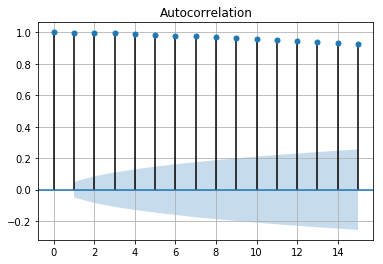

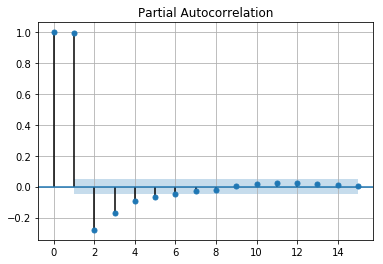

In [20]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
plot_acf(tomodel,lags=15)
plt.show()
plot_pacf(tomodel,lags=15)
plt.show()

On thoses plots you can observe blue shaded regions, those are confidence interevals (set to a 95% default value). Values of ACF or PACF outside of this region are likely to be correlations and not noise.

Observe the shape of the two plots:

    ACF plot decays gradually
    PACF shows a statistically significant spike at lag 1, 2, 3, 5 and none beyond lag 5

This is the sign of an auto-regressive AR(5) process.

To sum up:

    the signal is not stationary, so we can try to have d=1
    it seems to be an AR(5) process so p=5 and q=0

<div class="alert alert-info">
<h3><div class="label label-default">Question 12</div>  <div class="label label-info">Prediction using ARIMA</div></h3>
<br>

Now, train an ARIMA(5,1,0) model on the data, and then, use it to predict the next steps of <code>tomodel</code>. Compare it to <code>topredict</code>
</div>

In [21]:
from statsmodels.tsa.arima_model import ARIMA
from scipy.stats import probplot

ARmodel = ARIMA(#complete)
ARfitres = ARmodel.fit(trend='nc')


residuals = pd.DataFrame(ARfitres.resid)
residuals.plot()
plt.show()

probplot(ARfitres.resid, dist='norm',plot=plt)
plt.show()

plot_acf(ARfitres.resid,lags=15)
plt.show()

print(residuals.describe())

SyntaxError: invalid syntax (<ipython-input-21-bf19282bc1fa>, line 8)

In [22]:
model = ARIMA(#complete)
model_res = model.fit(disp=0)
newval = model_res.forecast(len(topredict))[0]

plt.plot(X[:len(tomodel)],tomodel)
plt.plot(X[len(tomodel):],topredict)
plt.plot(X[len(tomodel):],newval)
plt.show()


SyntaxError: invalid syntax (<ipython-input-22-71791350d1cb>, line 3)

We tried two models. We now want to compare them in a more scientific way, to select the best model.
<div class="alert alert-info">
<h3><div class="label label-default">Question 13</div>  <div class="label label-info">Compare models</div></h3>
<br>
Compute the mean squared error to compare the two models. Comment on the results, then comment on the two approaches.
</div>

In [ ]:
# Your code goes here

Your comment goes here...